# !WARNING!

In the original study, participants were shown a pair of faces in each trial: one face masculinised and one feminised. They then had to choose their preferred face. Which side the masculinised face was on (left or right) was randomised between trials.

In these notebooks, this dataset was analysed under the false assumption that the variable "side_of_response" corresponds to the participants choice of the "left" or "right" face, and therefore needed firstly to be mapped to a new variable, indicating whether the participant chose a masculine or feminine face - variable: "chose_masc". The mapping to "chose_masc" was created by viewing the masculinised/feminised images (not provided) to see which side (left or right) corresponded to the masculine or feminine.

**However the variable "side_of_response" (left=0, right=1) actually already corresponds to the variable "participant chose masculinised face" (feminised=0, masculinised=1).** Therefore the 3 analyses in the notebooks:  
* 0.1 Cleaning and Exploring Data (WRONG DATA).ipynb
* 0.2 Testing priming group independence (WRONG DATA).ipynb
* 0.3 Masculinity over 'time' (WRONG DATA).ipynb  

Are working with incorrectly interpreted data, and thus their analyses are also incorrect. 

The correct dataset and analyses are included in the notebooks:
* 1. Cleaning and Exploring Data.ipynb
* 2. Masculinity preferences by priming group.ipynb
* 3. Masculinity over 'time'.ipynb  
* 4. Modelling the data.ipynb

However these original incorrect notebooks are included within the project files for transparency, and to discourage similar mistakes being made by others re-using the dataset!

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Importing and pre-processing the data

In [3]:
# importing the data
data = pd.read_csv("../Main Study (Face)/main_study_face_data_modified_WRONG.csv")

In [4]:
# converting the boolean variable to integers, so it can be plotted
data["chose_masc_numerical"] = data["chose_masc"].map({True: 1, False: 0})

In [5]:
# converting the numerical prime conditions to the actual named condition, for clarity
data["prime_condition_names"] = data["prime_condition"].map({1:"neutral",
                                                             2:"male/male",
                                                             3:"male group",
                                                             4:"male/female",
                                                             5:"pathogen"})      

In [6]:
# converting the pre/post prime indicators to words, for clarity
data["pre_post_prime_name"] = data["pre_post_prime"].map({0:"pre-prime",     
                                                          1:"post-prime"})

In [7]:
data

,participant_id,trial_number,pre_post_prime,side_of_response,image,prime_condition,masc_side,chose_masc,chose_masc_numerical,prime_condition_names,pre_post_prime_name
0,11,2,0,0,Slide11.bmp,1,0,True,1,neutral,pre-prime
1,11,3,0,1,Slide9.bmp,1,1,True,1,neutral,pre-prime
2,11,4,0,0,Slide5.bmp,1,1,False,0,neutral,pre-prime
3,11,5,0,1,Slide1.bmp,1,1,True,1,neutral,pre-prime
4,11,6,0,1,Slide18.bmp,1,1,True,1,neutral,pre-prime
...,...,...,...,...,...,...,...,...,...,...,...
12659,75b,36,1,1,Slide20.bmp,5,1,True,1,pathogen,post-prime
12660,75b,37,1,1,Slide2.bmp,5,0,False,0,pathogen,post-prime
12661,75b,38,1,1,Slide10.bmp,5,0,False,0,pathogen,post-prime
12662,75b,39,1,0,Slide14.bmp,5,1,False,0,pathogen,post-prime


In [8]:
# creating a dataset containing only the post-prime values
only_post = data[data["pre_post_prime"]==1]

In [9]:
# creating a dataset containing only the pre-prime values
only_pre = data[data["pre_post_prime"]==0]

In [80]:
# creating a dataset where all the duplicated b participants are removed
b_participants = [p_id for p_id in list(data["participant_id"].unique()) if "b" in p_id and p_id[:-1] in list(data["participant_id"].unique())]
data_no_b = data[~data["participant_id"].isin(b_participants)]

In [81]:
# creating a dataset where the correction for the wrongly assigned image 10 result is reversed
data_10_wrong = data.copy()
data_10_wrong.update(~data_10_wrong[data_10_wrong["image"]=="Slide10.bmp"]["chose_masc"])
data_10_wrong["chose_masc_numerical"] = data_10_wrong["chose_masc"].map({True: 1, False: 0})

In [82]:
# creating a dataset where all the duplicated b participants are removed
# AND where the correction for the wrongly assigned image 10 result is reversed
data_10_wrong_no_b = data_no_b.copy()
data_10_wrong_no_b.update(~data_10_wrong_no_b[data_10_wrong_no_b["image"]=="Slide10.bmp"]["chose_masc"])
data_10_wrong_no_b["chose_masc_numerical"] = data_10_wrong_no_b["chose_masc"].map({True: 1, False: 0})

In [10]:
def residual_plots(model):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
    fig.subplots_adjust(wspace=0.25, hspace=0.25)
    fig.suptitle("Diagnostic Plots", fontsize=15)

    axes[0][0].hist(pd.Series(model.resid_pearson), bins=15, edgecolor="white", color="dodgerblue")
    sp.stats.probplot(pd.Series(model.resid_pearson), plot=axes[0][1], fit=True)
    axes[0][2].scatter(pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_y"],
                       pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_x"], 
                       alpha=0.7, s=10, color="dodgerblue")
    axes[0][2].axhline(y=0, color="red", linestyle="-")
    axes[1][0].scatter(list(pd.Series(model.get_influence().hat_matrix_diag).index),
                       pd.Series(model.get_influence().hat_matrix_diag), alpha=0.7, s=10, color="dodgerblue")
    axes[1][1].scatter(list(pd.Series(model.get_influence().cooks_distance[0]).index),
                       pd.Series(model.get_influence().cooks_distance[0]), alpha=0.7, s=10, color="dodgerblue")
    axes[1][2].scatter(abs(pd.DataFrame(model.resid_pearson).merge(pd.DataFrame(model.fittedvalues), 
                                                    left_index=True, right_index=True)["0_x"]),
                       pd.Series(model.get_influence().hat_matrix_diag), alpha=0.7, s=10, color="dodgerblue")

    axes[0][0].set_title("Residuals", fontsize=13)
    axes[0][0].text(0.55, 0.8, "Skew: {0:.2f}".format(pd.Series(model.resid_pearson).skew()), 
                    fontsize=12, horizontalalignment="left", transform=axes[0][0].transAxes,  
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    axes[0][1].set_xlabel(""), axes[0][1].set_ylabel(""), axes[0][1].set_title("Normal Plot", fontsize=13)
    axes[0][1].get_lines()[0].set_markerfacecolor("dodgerblue")
    axes[0][1].get_lines()[0].set_markersize(5)
    axes[0][1].get_lines()[0].set_markeredgecolor("None")
    axes[0][2].set_title("Fitted Values", fontsize=13), axes[0][2].set_ylabel("Standardised Residuals", fontsize=13, rotation=-90, labelpad=20)
    axes[1][0].set_title("Leverage", fontsize=13)
    axes[1][1].set_title("Cook's Distance", fontsize=13)
    axes[1][2].set_title("Residuals vs Leverage", fontsize=13);
    axes[1][2].set_xlabel("(Absolute) Standardised Residuals", fontsize=13), axes[1][2].set_ylabel("Leverage", fontsize=13, rotation=-90, labelpad=20),
    axes[1][2].yaxis.set_label_position("right"), axes[0][2].yaxis.set_label_position("right")
    axes[1][0].set_xlabel("Index", fontsize=13), axes[1][1].set_xlabel("Index", fontsize=13)

## Plotting the percent of preference for masculinity for each trial (i.e. over time)

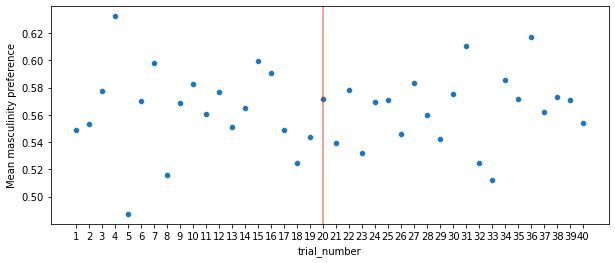

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=data.groupby("trial_number")["chose_masc_numerical"].mean(), ax=ax)
ax.axvline(20, color="red", alpha=0.5)
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

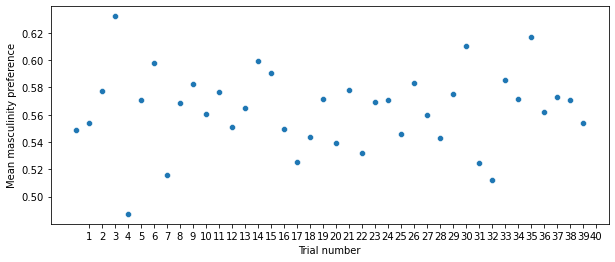

In [111]:
# checking that the mean calculation is correct (because it looks different compared to the study result!)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=pd.Series([np.mean(data[data["trial_number"]==trial_num]["chose_masc_numerical"]) for trial_num in range(1, 41)]), ax=ax)
ax.set_ylabel("Mean masculinity preference")
ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

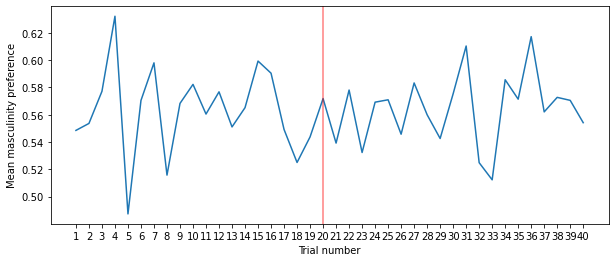

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby("trial_number")["chose_masc_numerical"].mean(), ax=ax)
ax.axvline(20, color="red", alpha=0.5)
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

In [13]:
#standard errors of the mean are fairly small
stats.sem(data[data["trial_number"]==1]["chose_masc_numerical"])

0.032393600173974677

In [91]:
## Does the data for this "increase over time", where time is the trial number, have a significant slope? No!
X_trial_time = sm.add_constant(data.groupby("trial_number")["chose_masc_numerical"].mean().reset_index()["trial_number"])
Y_trial_time = data.groupby("trial_number")["chose_masc_numerical"].mean().reset_index()["chose_masc_numerical"]
trial_time_model = sm.OLS(Y_trial_time, X_trial_time).fit()
trial_time_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     chose_masc_numerical   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                 -0.024
Method:                   Least Squares   F-statistic:                   0.07316
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):              0.788
Time:                          11:03:01   Log-Likelihood:                 85.519
No. Observations:                    40   AIC:                            -167.0
Df Residuals:                        38   BIC:                            -163.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5614      0.009     59.525      0.000       0.542       0.581
trial_number     0.0001      0.000      0.270      0.788      -0.001       0.001
==============================================================================
Omnibus:                        1.240   Durbin-Watson:                   2.403
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                0.448
Skew:                          -0.139   Prob(JB):                        0.799
Kurtosis:                       3.438   Cond. No.                         48.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

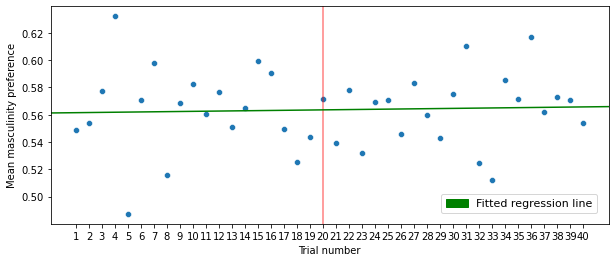

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=data.groupby("trial_number")["chose_masc_numerical"].mean(), ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)))
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
abline_plot(model_results=trial_time_model, ax=ax, color="green");
plt.legend(handles=[patches.Patch(color='green', label='Fitted regression line')], fontsize=11, loc=(0.7, 0.05)); 

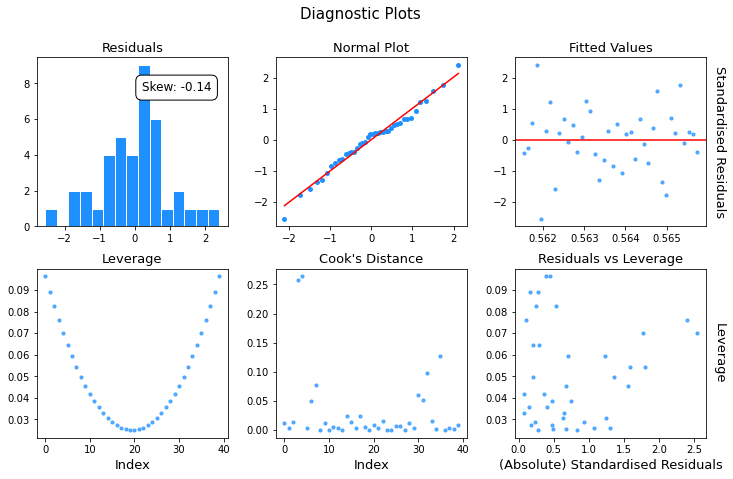

In [17]:
# there is more variation at the starting and ending trials, than in the middle
residual_plots(trial_time_model)

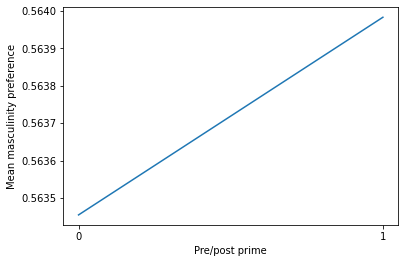

In [116]:
## Is this "increase over time" line, where instead time is the pre/post prime, significant? Only two data points, so can't tell!
ax = sns.lineplot(data=data.groupby("pre_post_prime")["chose_masc_numerical"].mean())
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Pre/post prime")
plt.xticks([0, 1]);

## Plotting the percent of preference for masculinity for each trial (i.e. over time), separated by priming group

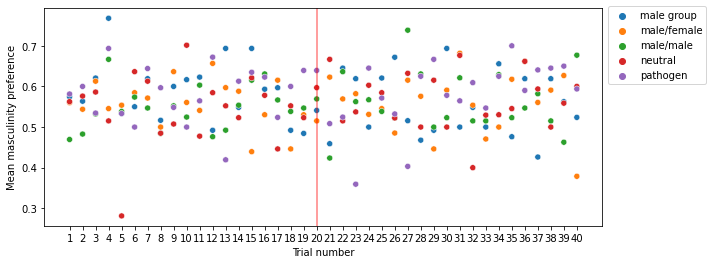

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.scatterplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc_numerical"].mean().reset_index(),
                x="trial_number", y="chose_masc_numerical", hue="prime_condition_names", ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.legend(loc=(1.01, 0.65))
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

In [22]:
# why is trial 5 neutral an outlier? Not sure! Not because of a limited number of participants or images.
trial_5_neut = data[(data["trial_number"]==5) & (data["prime_condition_names"]=="neutral") & (data["chose_masc_numerical"]==0)][["participant_id", "image"]]
trial_5_neut["participant_id"].unique()
trial_5_neut["image"].value_counts()

Slide16.bmp    6
Slide14.bmp    4
Slide2.bmp     4
Slide5.bmp     3
Slide3.bmp     3
Slide1.bmp     3
Slide13.bmp    3
Slide6.bmp     3
Slide19.bmp    2
Slide18.bmp    2
Slide4.bmp     2
Slide20.bmp    2
Slide12.bmp    2
Slide17.bmp    2
Slide8.bmp     2
Slide9.bmp     1
Slide15.bmp    1
Slide7.bmp     1
Name: image, dtype: int64

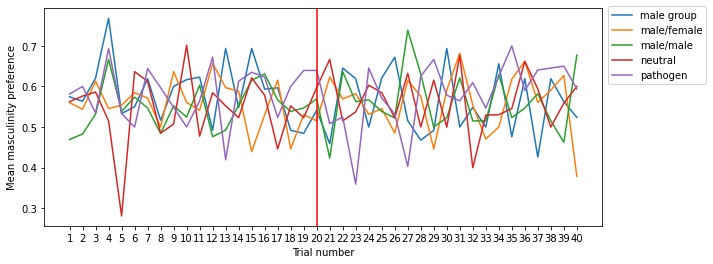

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc_numerical"].mean().reset_index(),
                x="trial_number", y="chose_masc_numerical", hue="prime_condition_names", ax=ax)
ax.axvline(20, color="red", alpha=1, markersize=2)
plt.legend(loc=(1.01, 0.65))
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.xticks(list(range(1, 41)));

In [24]:
# fitting a model, with both trial number and categorical priming conditions as explanatory variables
trial_time_prime_model = smf.ols(formula="chose_masc_numerical ~ trial_number + C(prime_condition_names)", 
                                data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc_numerical"].mean().reset_index()).fit()
trial_time_prime_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     chose_masc_numerical   R-squared:                       0.021
Model:                              OLS   Adj. R-squared:                 -0.004
Method:                   Least Squares   F-statistic:                    0.8240
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):              0.534
Time:                          10:29:18   Log-Likelihood:                 243.77
No. Observations:                   200   AIC:                            -475.5
Df Residuals:                       194   BIC:                            -455.8
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.5689      0.015     38.800      0.000       0.540       0.598
C(prime_condition_names)[T.male/female]    -0.0125      0.016     -0.770      0.442      -0.045       0.020
C(prime_condition_names)[T.male/male]      -0.0160      0.016     -0.988      0.325      -0.048       0.016
C(prime_condition_names)[T.neutral]        -0.0161      0.016     -0.991      0.323      -0.048       0.016
C(prime_condition_names)[T.pathogen]        0.0101      0.016      0.624      0.534      -0.022       0.042
trial_number                             9.819e-05      0.000      0.221      0.826      -0.001       0.001
==============================================================================
Omnibus:                        9.498   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.243
Skew:                          -0.375   Prob(JB):                      0.00362
Kurtosis:                       3.886   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# fitting a model to each priming condition individually - is there evidence that masc preference changes over time?
for i in range(1, 6):
    print("condition", {1:"neutral",2:"male/male",3:"male group",4:"male/female",5:"pathogen"}[i], "p-value:",
          smf.ols(formula="chose_masc_numerical ~ trial_number", 
                  data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc_numerical"].mean().reset_index()).fit().pvalues[1])

condition neutral p-value: 0.5412591810700396
condition male/male p-value: 0.3657347689633309
condition male group p-value: 0.1127133127160916
condition male/female p-value: 0.7095681715723677
condition pathogen p-value: 0.3199269643768015


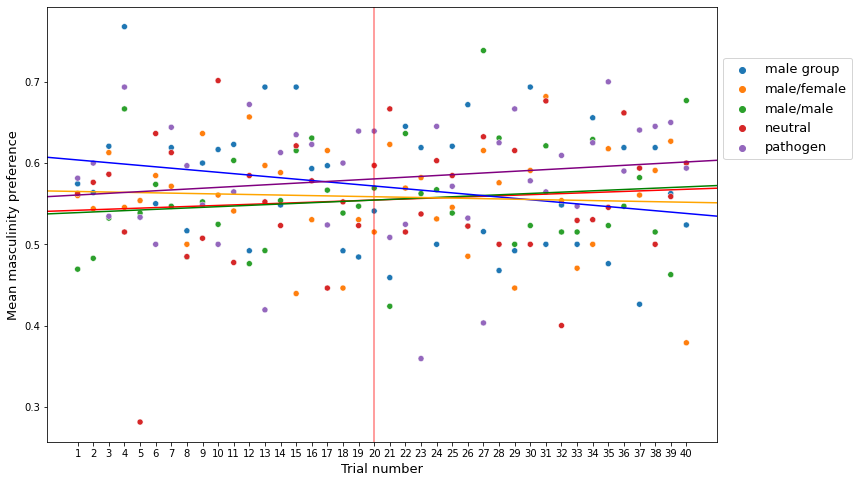

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(data=data.groupby(["prime_condition_names", "trial_number"])["chose_masc_numerical"].mean().reset_index(),
                x="trial_number", y="chose_masc_numerical", hue="prime_condition_names", ax=ax)
ax.axvline(20, color="red", alpha=0.5), plt.legend(loc=(1.01, 0.65), fontsize=13)
plt.xticks(list(range(1, 41)))
ax.set_ylabel("Mean masculinity preference", fontsize=13), ax.set_xlabel("Trial number", fontsize=13)
for i, colour in zip(range(1, 6), ["red", "green", "blue", "orange", "purple"]):
    abline_plot(ax=ax, color=colour,
                model_results=smf.ols(formula="chose_masc_numerical ~ trial_number", 
                                      data=data[data["prime_condition"]==i].groupby("trial_number")["chose_masc_numerical"].mean().reset_index()).fit())

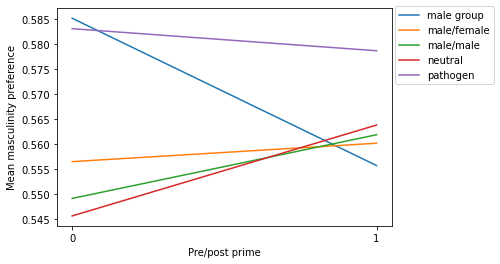

In [142]:
ax = sns.lineplot(data=data.groupby(["prime_condition_names", "pre_post_prime"])["chose_masc_numerical"].mean().reset_index(),
                x="pre_post_prime", y="chose_masc_numerical", hue="prime_condition_names")
plt.legend(loc=(1.01, 0.65)), ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Pre/post prime"), plt.xticks([0, 1]);

## What if you reverse the correction of the slide 10 masculinity side? What if you remove the b participants from the dataset? Do the results change?
(spoiler: no)

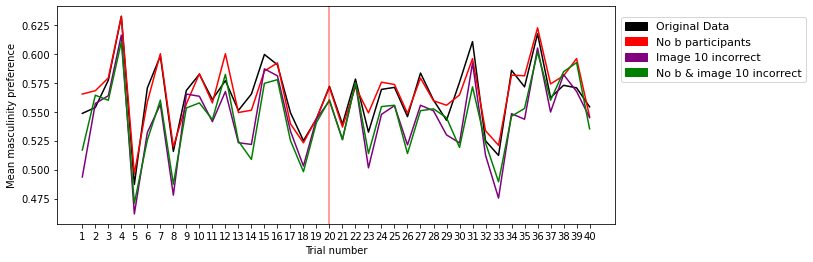

In [144]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby("trial_number")["chose_masc_numerical"].mean(), color="black", ax=ax)
sns.lineplot(data=data_no_b.groupby("trial_number")["chose_masc_numerical"].mean(), color="red", ax=ax)
sns.lineplot(data=data_10_wrong.groupby("trial_number")["chose_masc_numerical"].mean(), color="purple", ax=ax)
sns.lineplot(data=data_10_wrong_no_b.groupby("trial_number")["chose_masc_numerical"].mean(), color="green", ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)));
ax.set_ylabel("Mean masculinity preference"), ax.set_xlabel("Trial number")
plt.legend(handles=[patches.Patch(color='black', label='Original Data'), 
                    patches.Patch(color='red', label='No b participants'), 
                    patches.Patch(color='purple', label='Image 10 incorrect'), 
                    patches.Patch(color='green', label='No b & image 10 incorrect')], 
           fontsize=11, loc=(1.01, 0.65)); 

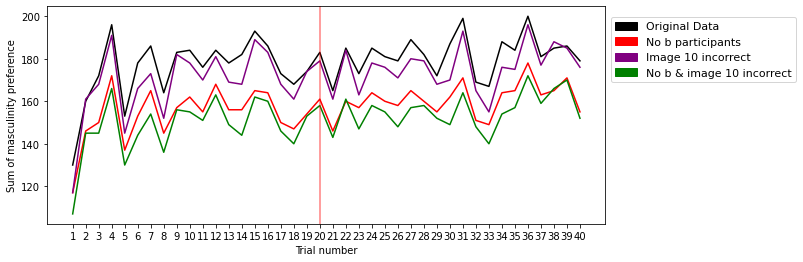

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.lineplot(data=data.groupby("trial_number")["chose_masc_numerical"].sum(), color="black", ax=ax)
sns.lineplot(data=data_no_b.groupby("trial_number")["chose_masc_numerical"].sum(), color="red", ax=ax)
sns.lineplot(data=data_10_wrong.groupby("trial_number")["chose_masc_numerical"].sum(), color="purple", ax=ax)
sns.lineplot(data=data_10_wrong_no_b.groupby("trial_number")["chose_masc_numerical"].sum(), color="green", ax=ax)
ax.axvline(20, color="red", alpha=0.5)
plt.xticks(list(range(1, 41)));
ax.set_ylabel("Sum of masculinity preference"), ax.set_xlabel("Trial number")
plt.legend(handles=[patches.Patch(color='black', label='Original Data'), 
                    patches.Patch(color='red', label='No b participants'), 
                    patches.Patch(color='purple', label='Image 10 incorrect'), 
                    patches.Patch(color='green', label='No b & image 10 incorrect')], 
           fontsize=11, loc=(1.01, 0.65)); 